<a href="https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/af/design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AfDesign (beta version)
Backprop through AlphaFold for protein design.

**WARNING**
1.   This notebook is in active development and was designed for demonstration purposes only.
2.   Using AfDesign as the only "loss" function for design might be a bad idea, you may find adversarial sequences (aka. sequences that trick AlphaFold).
3.   The current setup is limited to max length of ~256 amino acids length.

**CHANGE LOG**
*   07Feb2022 - refactored the optimizer code. Changed the default to NSGD (normalized SGD to match TrDesign).
*   08Feb2022 - fixed bug allowing msa design mode to work with `binder` design protocol
*   19Feb2022 - making `dropout` a dynamic option (can be turned on/off and rescaled during optimization)
*   20Feb2022 - `num_models`, `model_mode` and `model_parallel` options refactored.

In [ ]:
#@title install
%%bash
if [ ! -d af_backprop ]; then
  git clone https://github.com/sokrypton/af_backprop.git
  pip -q install biopython dm-haiku==0.0.5 ml-collections py3Dmol
fi
if [ ! -d params ]; then
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
fi
wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
wget -qnc https://raw.githubusercontent.com/sokrypton/ColabDesign/main/af/design.py

In [ ]:
#@title import libraries
import sys
sys.path.append('/content/af_backprop')

import os
from google.colab import files
import numpy as np
from IPython.display import HTML
from design import mk_design_model, clear_mem

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

In [ ]:
#@title ##define global options


##############################################################
# GET OPTIONS
##############################################################
#@markdown ###model options

num_models = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
#@markdown - `num_models` - number of model params to use at each iteration.
model_mode = "sample" #@param ["sample", "fixed"]
#@markdown - `sample` - randomly select models params to use. (Recommended)
#@markdown - `fixed` - use the same model params each iteration.
model_parallel = False #@param {type:"boolean"}
#@markdown - `model_parallel` - run model params in parallel if `num_models` > 1. (may speedup run, if you have access to high-end GPU)


#@markdown ###recycle options
num_recycles = 0 #@param ["0", "1", "2", "3"] {type:"raw"}
#@markdown - `num_recycles` - max number of recycles to use during design (for denovo proteins we find 0 is often enough)
recycle_mode = "sample" #@param ["sample", "add_prev", "last", "backprop"]
#@markdown - `sample` - at each iteration, randomly select number of recycles to use. (Recommended)
#@markdown - `add_prev` - add prediction logits (dgram, pae, plddt) across all recycles. (Most stable, but slow and requires more memory).
#@markdown - `last` - only use gradients from last recycle.
#@markdown - `backprop` - use outputs from last recycle, but backprop through all recycles.


OPT = {"num_models":num_models, "model_mode":model_mode, "model_parallel":model_parallel,
       "num_recycles":num_recycles, "recycle_mode":recycle_mode}

# fixed backbone design (fixbb)
For a given protein backbone, generate/design a new sequence that AlphaFold thinks folds into that conformation. 

---

**weights of the model**
- `dgram_cce` - minimizes the categorical-cross-entropy between predicted distogram (binned distance matrix) and one extracted from pdb
- `fape`      - minimize difference between coordinates (see AlphaFold paper)
- `pae`       - minimizes the predicted alignment error
- `plddt`     - maximizes the predicted LDDT
- `msa_ent`   - minimize entropy for MSA design (see example at the end of notebook)

**notes**
- `pae` and `plddt` values are between 0 and 1 (where lower is better for both)
- we find `dgram_cce` loss to be more stable for design (compared to `fape`)
- For **optimization** we provide 4 different functions:
 - `design_logits()` - optimize `logits` inputs (continious)
 - `design_prob()` - optimize `softmax(logits)` inputs (probabilities)

 For complex topologies, we find directly optimizing one_hot encoded sequence `design_prob(hard=True)` to be very challenging. To get around this problem, we propose optimizing in 2 or 3 stages.
 - `design_2stage()` - `prob` → `hard`
 - `design_3stage()` - `logits` → `prob` → `hard`


In [ ]:
#@markdown inputs
protocol = "fixbb"
pdb_code = "1TEN" #@param {type:"string"}
chain = "A" #@param ["A", "B", "C"] {allow-input: true}

clear_mem()
model = mk_design_model(**OPT, protocol=protocol)
model.prep_inputs(pdb_filename=get_pdb(pdb_code), chain=chain)

print("length",  model._len)
print("weights", model.opt["weights"])

length 89
weights {'msa_ent': 0.01, 'dgram_cce': 1.0, 'fape': 0.0, 'pae': 0.1, 'plddt': 0.1}


In [ ]:
# model.restart() is not needed the first time you run, but can be used to
# restart trajectory without needing to recompile the model
model.restart()
model.design_3stage()

1	model: [2] recycles: 0 soft: 0.000 temp: 0.500 loss: 5.211 seqid: 0.067 pae: 0.616 plddt: 0.428 dgram_cce: 5.107 fape: 4.990 rmsd: 43.601
2	model: [4] recycles: 0 soft: 0.003 temp: 0.500 loss: 7.868 seqid: 0.079 pae: 0.231 plddt: 0.042 dgram_cce: 7.841 fape: 4.755 rmsd: 38.054
3	model: [3] recycles: 0 soft: 0.007 temp: 0.500 loss: 5.103 seqid: 0.067 pae: 0.629 plddt: 0.374 dgram_cce: 5.003 fape: 3.297 rmsd: 25.573
4	model: [2] recycles: 0 soft: 0.010 temp: 0.500 loss: 5.892 seqid: 0.101 pae: 0.449 plddt: 0.222 dgram_cce: 5.825 fape: 5.063 rmsd: 41.474
5	model: [4] recycles: 0 soft: 0.013 temp: 0.500 loss: 6.056 seqid: 0.056 pae: 0.684 plddt: 0.348 dgram_cce: 5.953 fape: 6.650 rmsd: 55.002
6	model: [0] recycles: 0 soft: 0.017 temp: 0.500 loss: 5.528 seqid: 0.067 pae: 0.658 plddt: 0.383 dgram_cce: 5.424 fape: 4.128 rmsd: 33.258
7	model: [3] recycles: 0 soft: 0.020 temp: 0.500 loss: 4.809 seqid: 0.056 pae: 0.581 plddt: 0.366 dgram_cce: 4.714 fape: 3.188 rmsd: 24.139
8	model: [4] recycle

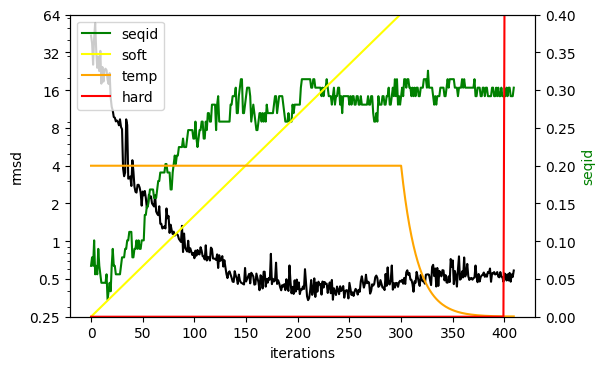

In [ ]:
model.plot_traj()  

In [ ]:
HTML(model.animate())

In [ ]:
model.plot_pdb()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
model.save_pdb(f"{pdb_code}.{model.protocol}.pdb")

# hallucination
For a given length, generate/hallucinate a protein sequence that AlphaFold thinks folds into a well structured protein (high plddt, low pae, many contacts).

---
**weights of the model**
- `con` - maximize number of contacts. (We find just minimizing `plddt` results in single long helix, and maximizing `pae` results in a two helix bundle. To encourage compact structures we add a `con` term)


In [ ]:
#@markdown inputs
protocol = "hallucination"
length =  100#@param {type:"raw"}
copies =  1#@param {type:"raw"}

clear_mem()
model = mk_design_model(**OPT, protocol=protocol)
model.prep_inputs(length=length, copies=copies)

print("length",model._len)
print("weights",model.opt["weights"])

In [ ]:
###########################
# For hallucination, default initialization often converges to all-helical proteins.
# For this task, we recommend gumbel initialization w/ design_2stage()
###########################
model.restart(seq_init="gumbel")
model.design_2stage()

1	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.083 pae: 0.673 plddt: 0.466 con: 1.888
2	model: [1] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.692 pae: 0.605 plddt: 0.474 con: 1.227
3	model: [2] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.408 pae: 0.551 plddt: 0.472 con: 0.770
4	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.380 pae: 0.559 plddt: 0.537 con: 0.569
5	model: [4] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.155 pae: 0.472 plddt: 0.430 con: 0.505
6	model: [2] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.142 pae: 0.457 plddt: 0.445 con: 0.479
7	model: [1] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.100 pae: 0.440 plddt: 0.399 con: 0.523
8	model: [4] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.067 pae: 0.429 plddt: 0.396 con: 0.484
9	model: [3] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.006 pae: 0.387 plddt: 0.416 con: 0.405
10	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.147 pae: 0.462 plddt: 0.488 con: 0.393
11	model: [0] recycles: 0 soft: 1.000 t

In [ ]:
HTML(model.animate())

In [ ]:
model.get_seqs()

['EHHSDVIIWICDSQNASWSLFCGKASDHQLKQWAREVNDLGMCFCYVSESYPDFRCESGPNSPWCSDDSCQMMTEMMLQAHPECASEAKRLTELAQAKRA']

In [ ]:
model.plot_pdb()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
model.save_pdb(f"{model.protocol}.pdb")

# binder hallucination
For a given protein target and protein binder length, generate/hallucinate a protein binder sequence AlphaFold thinks will bind to the target structure. To do this, we minimize PAE and maximize number of contacts at the interface and within the binder, and we maximize pLDDT of the binder.

---
**weights of the model**
- `pae_inter` - minimize PAE interface of the proteins
- `pae_intra` - minimize PAE within binder
- `con_inter` - maximize number of contacts at the interface of the proteins
- `con_intra` - maximize number of contacts within binder

In [ ]:
#@markdown inputs
protocol = "binder"
pdb_code = "4MZK" #@param {type:"string"}
chain = "A" #@param ["A", "B", "C"] {allow-input: true}
binder_length =  19#@param {type:"integer"}

clear_mem()
model = mk_design_model(**OPT, protocol=protocol)
model.prep_inputs(pdb_filename=get_pdb(pdb_code), chain=chain,
                         binder_len=binder_length)

print("target_length",model._target_len)
print("binder_length",model._binder_len)

target_length 142
binder_length 19


In [ ]:
model.restart()
model.design_2stage()

1	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.294 pae_inter: 0.864 pae_intra: 0.188 plddt: 0.364 con_intra: 1.717 con_inter: 3.900
2	model: [1] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.252 pae_inter: 0.915 pae_intra: 0.202 plddt: 0.417 con_intra: 1.590 con_inter: 3.517
3	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.328 pae_inter: 0.861 pae_intra: 0.197 plddt: 0.393 con_intra: 1.725 con_inter: 3.900
4	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.158 pae_inter: 0.861 pae_intra: 0.194 plddt: 0.348 con_intra: 1.540 con_inter: 3.589
5	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.142 pae_inter: 0.851 pae_intra: 0.190 plddt: 0.371 con_intra: 1.575 con_inter: 3.428
6	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 2.288 pae_inter: 0.867 pae_intra: 0.191 plddt: 0.379 con_intra: 1.621 con_inter: 3.897
7	model: [0] recycles: 0 soft: 1.000 temp: 1.000 loss: 1.987 pae_inter: 0.839 pae_intra: 0.209 plddt: 0.391 con_intra: 1.524 con_inter: 2.767
8	mode

In [ ]:
HTML(model.animate())

In [ ]:
model.get_seqs()

['NGALRRLLRRLQEQWWNQE']

In [ ]:
model.plot_pdb()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
model.save_pdb(f"{model.protocol}.pdb")

#EXTRAS

# fixbb - MSA design
Instead of generating/designing a single sequence that AlphaFold thinks will fold into desired structure, we can generate an entire MSA. 

- WARNING: The more free parameterizer the more likely you will find an adverserial input. To avoid this we add an entropy term... but it might not be enough.

- Note: MSA design has only been tested for `fixbb`  protocol.

In [ ]:
#@markdown inputs
protocol = "fixbb"
pdb_code = "6WVS" #@param {type:"string"}
chain = "A" #@param ["A", "B", "C"] {allow-input: true}
num_seq = 32 #@param {type:"integer"}

clear_mem()
model = mk_design_model(**OPT, protocol=protocol, num_seq=num_seq)
model.prep_inputs(pdb_filename=get_pdb(pdb_code), chain=chain)

In [ ]:
# increase entropy weight every 50 iterations
# note: entropy weight is intended to push the sequences to be similar to eachother
# to avoid MSA from being trapped in local minimum, we start with low entropy weight and then increase
design_model.design_hard(50, weights={"plddt":0.0,"pae":0.0,"msa_ent":0.01})
for ent in [0.02,0.04,0.08,0.16,0.32]:
  design_model._best_loss = np.inf # reset loss (since we want the best result saved with high entropy weight)
  design_model.design_hard(50, weights={"plddt":0.1,"pae":0.1,"msa_ent":ent}, save_best=True)

In [ ]:
HTML(design_model.animate())

In [ ]:
design_model.get_seqs()